# Introduction to Planning for Self Driving Vehicles

In this notebook you are going to train your own ML policy to fully control an SDV. You will train your model using the Lyft Prediction Dataset and [L5Kit](https://github.com/woven-planet/l5kit).

**Before starting, please download the [Lyft L5 Prediction Dataset 2020](https://self-driving.lyft.com/level5/prediction/) and follow [the instructions](https://github.com/woven-planet/l5kit#download-the-datasets) to correctly organise it.**

The policy will be a deep neural network (DNN) which will be invoked by the SDV to obtain the next command to execute.

More in details, you will be working with a CNN architecture based on ResNet50.

![model](../../docs/images/planning/model.svg)


#### Inputs
The network will receive a Bird's-Eye-View (BEV) representation of the scene surrounding the SDV as the only input. This has been rasterised in a fixed grid image to comply with the CNN input. L5Kit is shipped with various rasterisers. Each one of them captures different aspects of the scene (e.g. lanes or satellite view).

This input representation is very similar to the one used in the [prediction competition](https://www.kaggle.com/c/lyft-motion-prediction-autonomous-vehicles/overview). Please refer to our [competition baseline notebook](../agent_motion_prediction/agent_motion_prediction.ipynb) and our [data format notebook](../visualisation/visualise_data.ipynb) if you want to learn more about it.

#### Outputs
The network outputs the driving signals required to fully control the SDV. In particular, this is a trajectory of XY and yaw displacements which can be used to move and steer the vehicle.

After enough training, your model will be able to drive an agent along a specific route. Among others, it will do lane-following while respecting traffic lights.

Let's now focus on how to train this model on the available data.

### Training using imitation learning
The model is trained using a technique called *imitation learning*. We feed examples of expert driving experiences to the model and expect it to take the same actions as the driver did in those episodes. Imitation Learning is a subfield of supervised learning, in which a model tries to learn a function f: X -> Y describing given input / output pairs - one prominent example of this is image classification.

This is also the same concept we use in our [motion prediction notebook](../agent_motion_prediction/agent_motion_prediction.ipynb), so feel free to check that out too.

##### Imitation learning limitations

Imitation Learning is powerful, but it has a strong limitation. It's not trivial for a trained model to generalise well on out-of-distribution data.

After training the model, we would like it to take full control and drive the AV in an autoregressive fashion (i.e. by following its own predictions).

During evaluation it's very easy for errors to compound and make the AV drift away from the original distribution. In fact, during training our model has seen only good examples of driving. In particular, this means **almost perfect midlane following**. However, even a small constant displacement during evaluation can accumulate enough error to lead the AV completely out of its distribution in a matter of seconds.

![drifting](../../docs/images/planning/drifting.svg)

This is a well known issue in SDV control and simulation discussed, among others, in [this article](https://ri.cmu.edu/pub_files/2010/5/Ross-AIStats10-paper.pdf).

# Adding perturbations to the mix

One of the simplest techniques to ensure a good generalisation is **data augmentation**, which exposes the network to different versions of the input and helps it to generalise better to out-of-distribution situations.

In our setting, we want to ensure that **our model can recover if it ends up slightly off the midlane it is following**.

Following [the noteworthy approach from Waymo](https://arxiv.org/pdf/1812.03079.pdf), we can enrich the training set with **online trajectory perturbations**. These perturbations are kinematically feasible and affect both starting angle and position. A new ground truth trajectory is then generated to link this new starting point with the original trajectory end point. These starting point will be slightly rotated and off the original midlane, and the new trajectory will teach the model how to recover from this situation.

![perturbation](../../docs/images/planning/perturb.svg)


In the following cell, we load the training data and leverage L5Kit to add these perturbations to our training set.
We also plot the same example with and without perturbation. During training, our model will see also those examples and learn how to recover from positional and angular offsets.

In [33]:
from tempfile import gettempdir
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm

from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.geometry import transform_points
from l5kit.visualization import TARGET_POINTS_COLOR, draw_trajectory
from l5kit.planning.rasterized.model import RasterizedPlanningModel
from l5kit.kinematic import AckermanPerturbation
from l5kit.random import GaussianRandomGenerator

import os

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [34]:
!echo $PWD
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/mnt/scratch/v_liuhaolan/l5kit_data"
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./nmp-config.yaml")

/mnt/home/v_liuhaolan/l5kit/examples/planning


In [35]:
perturb_prob = cfg["train_data_loader"]["perturb_probability"]

# rasterisation and perturbation
rasterizer = build_rasterizer(cfg, dm)
mean = np.array([0.0, 0.0, 0.0])  # lateral, longitudinal and angular
std = np.array([0.5, 1.5, np.pi / 6])

"""
perturbation = AckermanPerturbation(
        random_offset_generator=GaussianRandomGenerator(mean=mean, std=std), perturb_prob=perturb_prob)

# ===== INIT DATASET
train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()
train_dataset = EgoDataset(cfg, train_zarr, rasterizer, perturbation)

# plot same example with and without perturbation
for perturbation_value in [1, 0]:
    perturbation.perturb_prob = perturbation_value

    data_ego = train_dataset[0]
    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))
    target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    plt.imshow(im_ego)
    plt.axis('off')
    plt.show()

# before leaving, ensure perturb_prob is correct
perturbation.perturb_prob = perturb_prob
"""

'\nperturbation = AckermanPerturbation(\n        random_offset_generator=GaussianRandomGenerator(mean=mean, std=std), perturb_prob=perturb_prob)\n\n# ===== INIT DATASET\ntrain_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()\ntrain_dataset = EgoDataset(cfg, train_zarr, rasterizer, perturbation)\n\n# plot same example with and without perturbation\nfor perturbation_value in [1, 0]:\n    perturbation.perturb_prob = perturbation_value\n\n    data_ego = train_dataset[0]\n    im_ego = rasterizer.to_rgb(data_ego["image"].transpose(1, 2, 0))\n    target_positions = transform_points(data_ego["target_positions"], data_ego["raster_from_agent"])\n    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)\n    plt.imshow(im_ego)\n    plt.axis(\'off\')\n    plt.show()\n\n# before leaving, ensure perturb_prob is correct\nperturbation.perturb_prob = perturb_prob\n'

In [36]:
# ===== INIT DATASET
train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()
train_dataset = EgoDataset(cfg, train_zarr, rasterizer)

In [37]:
from l5kit.planning.rasterized.nmp_model import NMPPlanningModel


model = NMPPlanningModel(
        model_arch="simple_cnn",
        num_input_channels=rasterizer.num_channels(),
#        num_targets=3 * cfg["model_params"]["future_num_frames"],  # X, Y, Yaw * number of future states,
        num_targets = cfg["raster_params"]["raster_size"][0]*cfg["raster_params"]["raster_size"][1],
        weights_scaling= [1., 1., 1.],
        criterion=nn.MSELoss(reduction="none")
        )
print(model)


NMPPlanningModel(
  (criterion): MSELoss()
  (model): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): GroupNorm(4, 64, eps=1e-05, affine=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (5): GroupNorm(2, 32, eps=1e-05, affine=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1568, out_features=12544, bias=True)
  )
)


In [38]:
#print(cfg["raster_params"]["raster_size"][0]*cfg["raster_params"]["raster_size"][1])

# Prepare for training
Our `EgoDataset` inherits from PyTorch `Dataset`; so we can use it inside a `Dataloader` to enable multi-processing.

In [39]:
train_cfg = cfg["train_data_loader"]


train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"], 
                             num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   134622   |  33437057  | 2655096629 |   314473872   |      928.68     |        248.38        |        79.41         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [40]:
losses_train = []
model.train()
torch.set_grad_enabled(True)

epoch_num = cfg["train_params"]["epochs"]
#

sample_data = next(iter(train_dataloader))

In [9]:
sample_data = next(iter(train_dataloader))
sample_data = {k: v.to(device) for k, v in sample_data.items()}
outputs = model(sample_data)

print(outputs["cost_map"].shape)

# visualize the cost map!
cost_image = outputs["cost_map"][0].reshape(112, 112)

#print(cost_image)

"""
from torchvision import transforms
 
# define custom transform
# here we are using our calculated
# mean & std

# get normalized image
#img_normalized = transform_norm(cost_image.numpy())
 
# convert this image to numpy array
img_normalized = np.array(cost_image.cpu().detach())
 
# transpose from shape of (3,,) to shape of (,,3)
#img_normalized = img_normalized.transpose(1, 0)
 
# display the normalized image
plt.imshow(img_normalized)
plt.xticks([])
plt.yticks([])


original_traj = sample_data['target_positions']#.to(device)

device = "cpu"

import random 

# a torch version of sampling negative trajectories
def batch_sample_traj(history_traj):
    res_traj = history_traj.clone().detach()
 
    shooting_delta = random.randint(-6, 6)/10.0
    batch_size = original_traj.shape[0]
    history_length = original_traj.shape[1]
    
    # vectorize the operation
    delta_traj = torch.zeros(history_length, 2).to(device)
    delta = 0.05 if shooting_delta > 0 else -0.05
    
    for i in range(history_length):
        delta = delta + shooting_delta
        delta_traj[i][1] += delta

    batch_delta_traj = delta_traj.unsqueeze(0).repeat(batch_size, 1, 1)
    
    print(batch_delta_traj.shape)
#    for j in range(batch_size):
#        delta = 0.05
#        for i in range(history_length):
#            delta = delta + shooting_delta
#            res_traj[j][i][1] += delta

    return res_traj + batch_delta_traj


import time
start = time.time()
negative_traj = batch_sample_traj(original_traj)
print("time: {} s".format(time.time()-start))

"""



torch.Size([64, 112, 112])


'\nfrom torchvision import transforms\n \n# define custom transform\n# here we are using our calculated\n# mean & std\n\n# get normalized image\n#img_normalized = transform_norm(cost_image.numpy())\n \n# convert this image to numpy array\nimg_normalized = np.array(cost_image.cpu().detach())\n \n# transpose from shape of (3,,) to shape of (,,3)\n#img_normalized = img_normalized.transpose(1, 0)\n \n# display the normalized image\nplt.imshow(img_normalized)\nplt.xticks([])\nplt.yticks([])\n\n\noriginal_traj = sample_data[\'target_positions\']#.to(device)\n\ndevice = "cpu"\n\nimport random \n\n# a torch version of sampling negative trajectories\ndef batch_sample_traj(history_traj):\n    res_traj = history_traj.clone().detach()\n \n    shooting_delta = random.randint(-6, 6)/10.0\n    batch_size = original_traj.shape[0]\n    history_length = original_traj.shape[1]\n    \n    # vectorize the operation\n    delta_traj = torch.zeros(history_length, 2).to(device)\n    delta = 0.05 if shooting_de

In [41]:
print(sample_data['target_positions'].device)
print(sample_data["target_positions_pixels"].shape)
#print(sample_data["negative_positions_pixels"])

cpu
torch.Size([64, 12, 2])


In [11]:
#sample_data["negative_positions_pixels"]


In [12]:
#transform_points(sampled_positions_maps, data["raster_from_agent"])
"""

pixel_size = (cfg['raster_params']['pixel_size'][0])

# TODO: runtime checking when the sampling trajectory will move out of the rasterized image
def max_margin_loss(batch_negative_index, batch_gt_index, cost_map):
    # calculate the costs aggregated with regard to time.
    batch_size = 64
    traj_size = 12
    loss = 0
    for i in range(batch_size):
        each_loss = 0
        diff = batch_gt_index[i] - batch_negative_index[i]
        diff = torch.sum(torch.pow(torch.sum(torch.pow(diff, 2),dim=1),0.5), dim=0).item()
#        print(diff*pixel_size)
        
        for j in range(traj_size):
            time_step = cost_map[i][batch_gt_index[i][j][0]][batch_gt_index[i][j][1]] - cost_map[i][batch_negative_index[i][j][0]][batch_negative_index[i][j][1]] + diff*pixel_size
#            print(time_step)
            if time_step > 0:
                each_loss = each_loss + (time_step)
        loss = loss + each_loss
    return loss / batch_size

import time
start = time.time()

#print(sample_data)
#data_batch["negative_positions_pixels"], data_batch["target_positions_pixels"], outputs["cost_map"]

r = max_margin_loss(sample_data["negative_positions_pixels"], sample_data["target_positions_pixels"], outputs["cost_map"])
print(r)
print("time: {} s".format(time.time()-start))
"""
# cpu 0.083
# gpu: 0.171 needs to be vectorized!

'\n\npixel_size = (cfg[\'raster_params\'][\'pixel_size\'][0])\n\n# TODO: runtime checking when the sampling trajectory will move out of the rasterized image\ndef max_margin_loss(batch_negative_index, batch_gt_index, cost_map):\n    # calculate the costs aggregated with regard to time.\n    batch_size = 64\n    traj_size = 12\n    loss = 0\n    for i in range(batch_size):\n        each_loss = 0\n        diff = batch_gt_index[i] - batch_negative_index[i]\n        diff = torch.sum(torch.pow(torch.sum(torch.pow(diff, 2),dim=1),0.5), dim=0).item()\n#        print(diff*pixel_size)\n        \n        for j in range(traj_size):\n            time_step = cost_map[i][batch_gt_index[i][j][0]][batch_gt_index[i][j][1]] - cost_map[i][batch_negative_index[i][j][0]][batch_negative_index[i][j][1]] + diff*pixel_size\n#            print(time_step)\n            if time_step > 0:\n                each_loss = each_loss + (time_step)\n        loss = loss + each_loss\n    return loss / batch_size\n\nimport tim

# Training loop
Here, we purposely include a barebone training loop. Clearly, many more components can be added to enrich logging and improve performance. Still, the sheer size of our dataset ensures that a reasonable performance can be obtained even with this simple loop.

In [42]:
#tr_it = iter(train_dataloader)
#progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))

optimizer = optim.Adam(model.parameters(), lr=1e-4)
epoch_num = 16

for epochs in range(epoch_num):
    
    iter_bar = tqdm(train_dataloader, desc='Iter (loss=X.XXX)')
    for step,batch in enumerate(iter_bar):
        # Forward pass
        batch = {k: v.to(device) for k, v in batch.items()}
        result = model(batch)
        loss = result["loss"]
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#        if step%10000 == 0:
#            print("model save")
#            torch.save(model.state_dict(),"./planning_model.pt")

        losses_train.append(loss.item())
        iter_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")


loss: 2.757925033569336 loss(avg): 12.353969494638418:   0%| | 2326/522455 [14:1


KeyboardInterrupt: 

### Plot the train loss curve
We can plot the train loss against the iterations (batch-wise) to check if our model has converged.

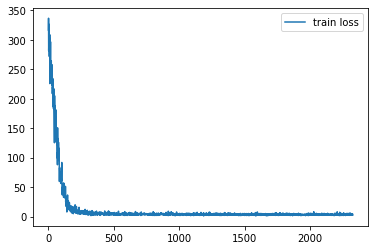

In [43]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

In [52]:
sample_data["image"].shape

torch.Size([64, 5, 112, 112])

torch.Size([64, 112, 112])


'\nim = np.array(sample_data["image"][idx].cpu().detach()).transpose(1, 2, 0)\nim = train_dataset.rasterizer.to_rgb(im)\ntarget_positions_pixels = transform_points(sample_data["target_positions"][idx].cpu().numpy(), sample_data["raster_from_agent"][idx].cpu().numpy())\ndraw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=sample_data["target_yaws"][idx].cpu().numpy())\n'

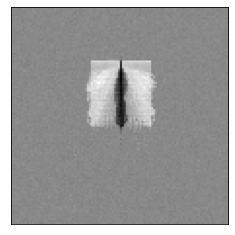

In [60]:
# visualize the costmap
sample_data = next(iter(train_dataloader))
for i in range(10):
    sample_data = next(iter(train_dataloader))
sample_data = {k: v.to(device) for k, v in sample_data.items()}
outputs = model(sample_data)

print(outputs["cost_map"].shape)

# visualize the cost map!
idx = 2
cost_image = outputs["cost_map"][idx].reshape(112, 112)

#print(cost_image)


from torchvision import transforms
 
# define custom transform
# here we are using our calculated
# mean & std

# get normalized image
#img_normalized = transform_norm(cost_image.numpy())
 
# convert this image to numpy array
img_normalized = np.array(cost_image.cpu().detach())
 
# transpose from shape of (3,,) to shape of (,,3)
#img_normalized = img_normalized.transpose(1, 0)
 
# display the normalized image
plt.imshow(img_normalized, cmap='gray')
plt.xticks([])
plt.yticks([])

"""
im = np.array(sample_data["image"][idx].cpu().detach()).transpose(1, 2, 0)
im = train_dataset.rasterizer.to_rgb(im)
target_positions_pixels = transform_points(sample_data["target_positions"][idx].cpu().numpy(), sample_data["raster_from_agent"][idx].cpu().numpy())
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=sample_data["target_yaws"][idx].cpu().numpy())
"""


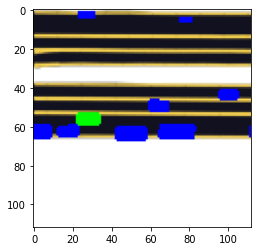

In [61]:
im = np.array(sample_data["image"][idx].cpu().detach()).transpose(1, 2, 0)
im = train_dataset.rasterizer.to_rgb(im)
#target_positions_pixels = transform_points(sample_data["target_positions"][idx].cpu().numpy(), sample_data["raster_from_agent"][idx].cpu().numpy())
#draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=sample_data["target_yaws"][idx].cpu().numpy())
plt.imshow(im)
plt.show()



In [22]:
print(img_normalized[55][65])


17.184238


# Store the model

Let's store the model as a torchscript. This format allows us to re-load the model and weights without requiring the class definition later.

**Take note of the path, you will use it later to evaluate your planning model!**

In [ ]:
to_save = torch.jit.script(model.cpu())
path_to_save = f"{gettempdir()}/planning_model.pt"
to_save.save(path_to_save)
print(f"MODEL STORED at {path_to_save}")

# Congratulations in training your first ML policy for planning!
### What's Next

Now that your model is trained and safely stored, you can evaluate how it performs in two very different situations using our dedicated notebooks:

### [Open-loop evaluation](./open_loop_test.ipynb)
In this setting the model **is not controlling the AV**, and predictions are used to compute metrics only.

### [Closed-loop evaluation](./closed_loop_test.ipynb)
In this setting the model **is in full control of the AV** future movements.

## Pre-trained models
we provide a collection of pre-trained models for the planning task:
- [model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/planning_models/planning_model_20201208.pt) trained on  train.zarr for 15 epochs;
- [model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/planning_models/planning_model_20201208_early.pt) trained on train.zarr for 2 epochs;
- [model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/planning_models/planning_model_20201208_nopt.pt) trained on train.zarr with perturbations disabled for 15 epochs;
- [model](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/planning_models/planning_model_20201208_nopt_early.pt) trained on train.zarr with perturbations disabled for 2 epochs;

We include two partially trained models to emphasise the important role of perturbations during training, especially during the first stage of training.

To use one of the models simply download the corresponding `.pt` file and load it in the evaluation notebooks.